# HAT-P-1

**Note**: HAT-P-1 has a very nearby companion on the detector, which in this case will break some of the `ombre` assumptions if we don't mask it first. In this notebook we first calculate the spectrum for the target, but we also calculate the spectrum for the (brighter) companion star so we can use it as a comparison.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import astropy.units as u
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
name = 'HAT-P-1'

## HAT-P-1

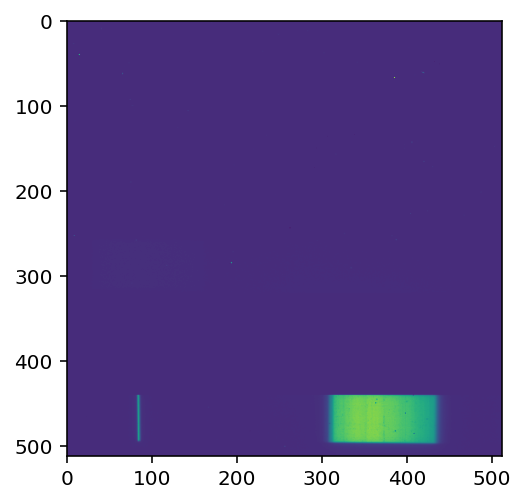

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
pixel_mask = np.ones((512, 512))
pixel_mask[320:440] = 0
plt.imshow(fits.open(fnames[100])[1].data * pixel_mask)

In [5]:
obs = om.Observation.from_files(fnames, pixel_mask=pixel_mask)

/Users/ch/HST/projects/ombre/src/ombre/visit.py:208: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10


In [6]:
clc = lk.search_lightcurve(name, author='QLP').download_all().stitch().remove_nans().flatten(201)
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

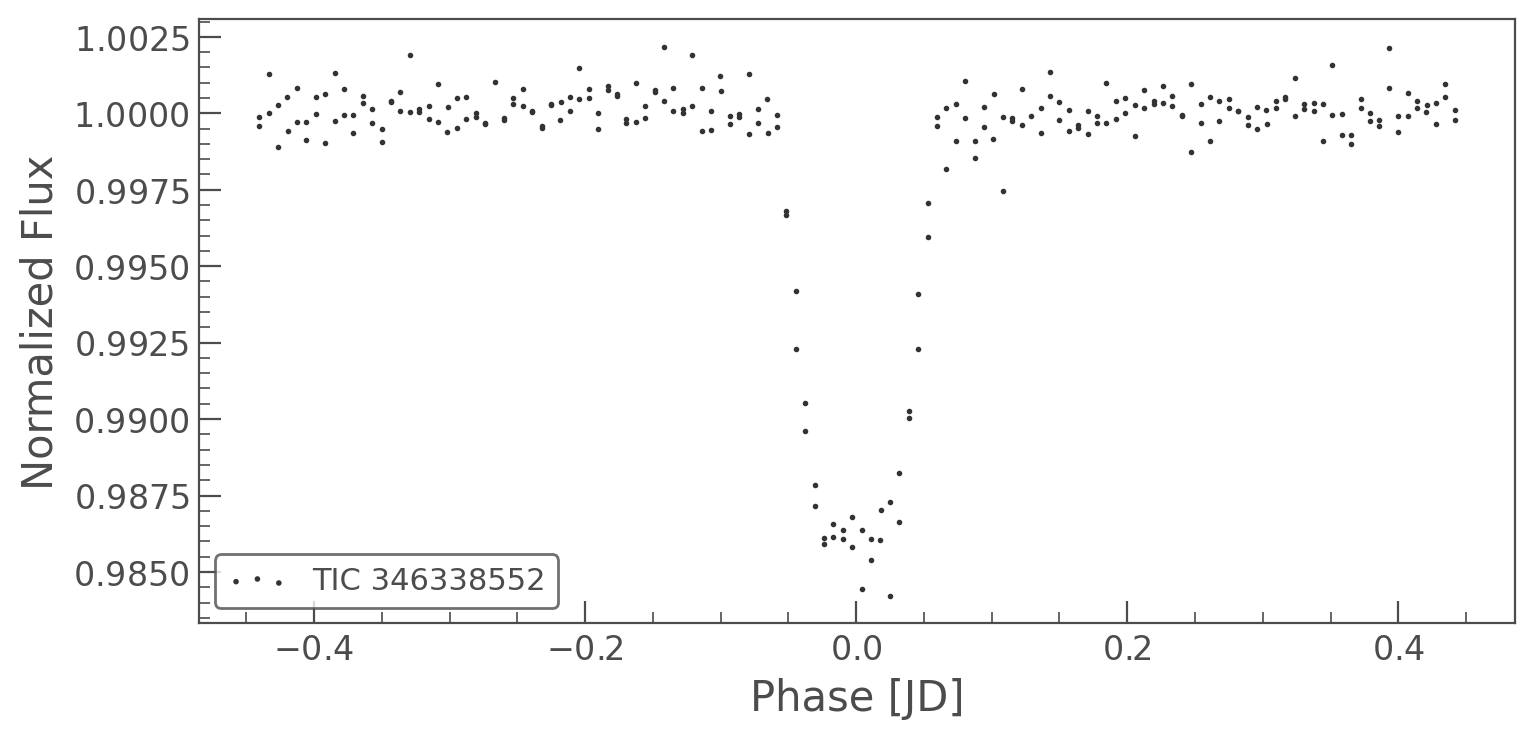

In [7]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [8]:
obs.fit_transit(x_suppl=clc.time.value + 2457000,
                y_suppl=clc.flux.value/np.median(clc.flux.value),
                yerr_suppl=clc.flux_err.value/np.median(clc.flux.value),
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

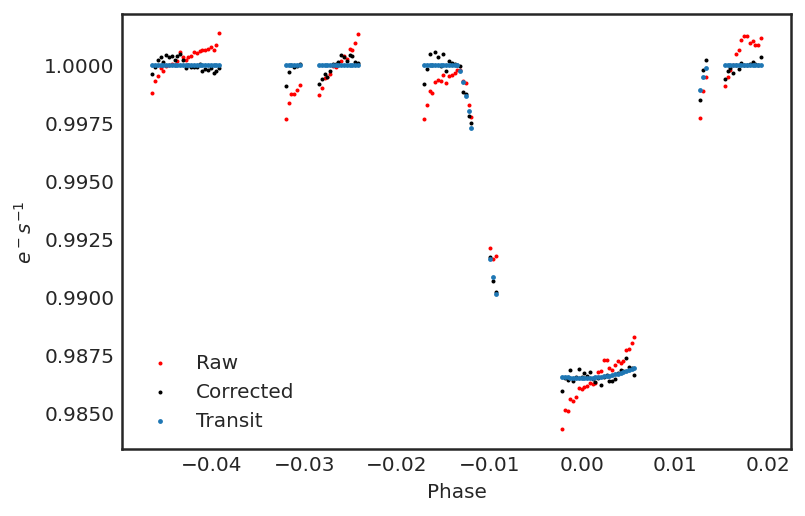

In [9]:
obs.plot()

In [10]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model: 100%|██████████| 1/1 [00:16<00:00, 16.06s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 1/1 [00:16<00:00, 16.06s/it]

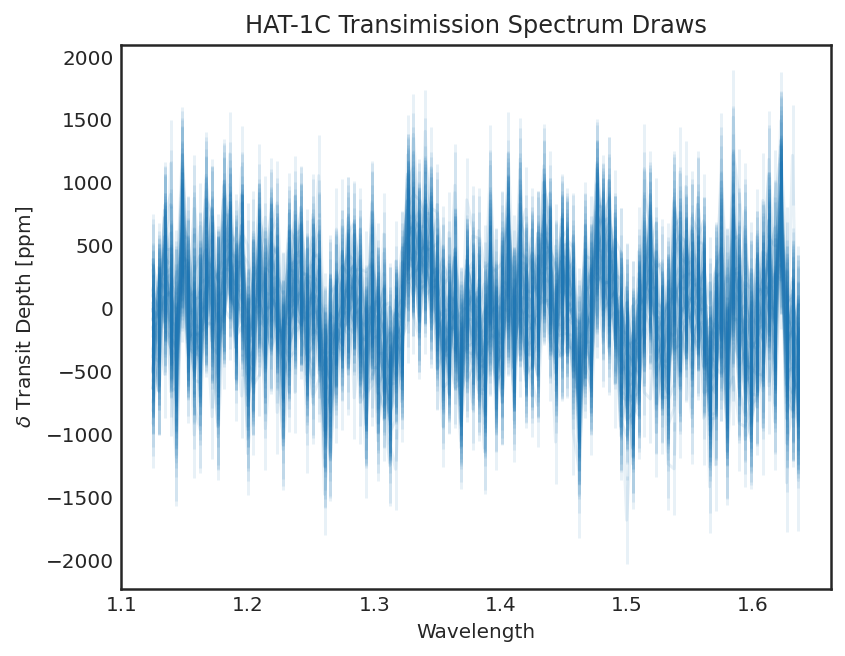

In [11]:
obs.plot_spectra()

<AxesSubplot:title={'center':'HAT-1C Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

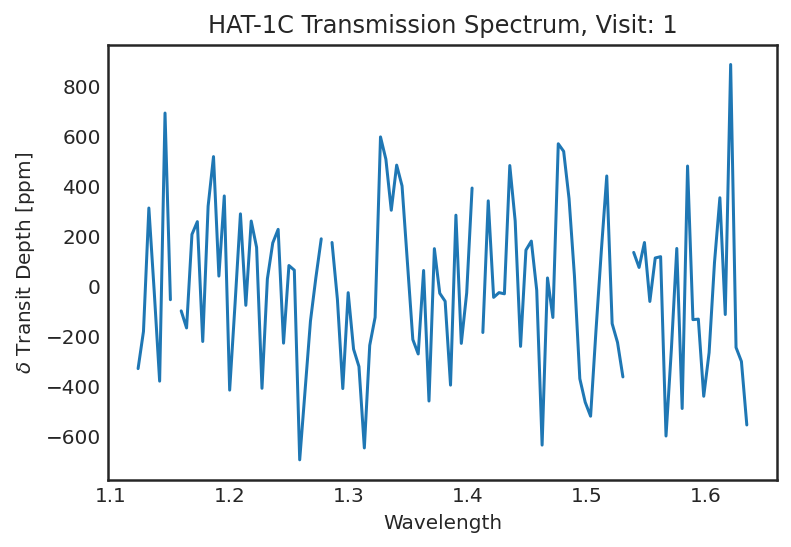

In [12]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

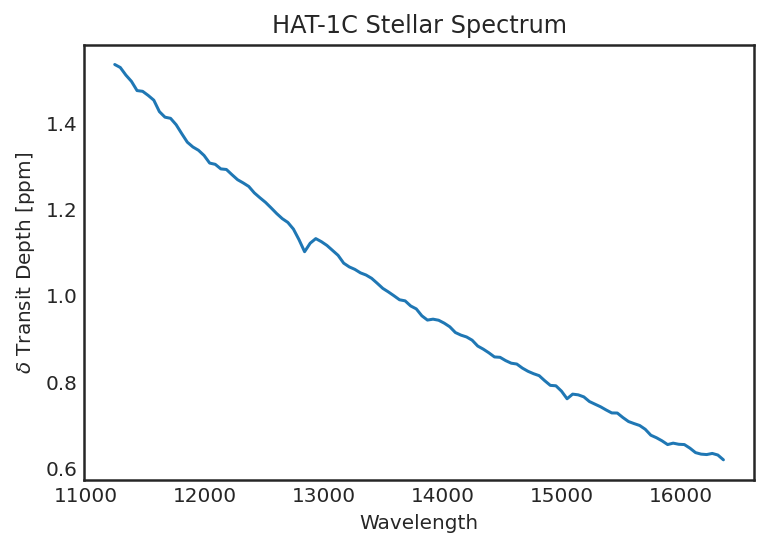

In [13]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [14]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits', overwrite=True)
except:
    pass

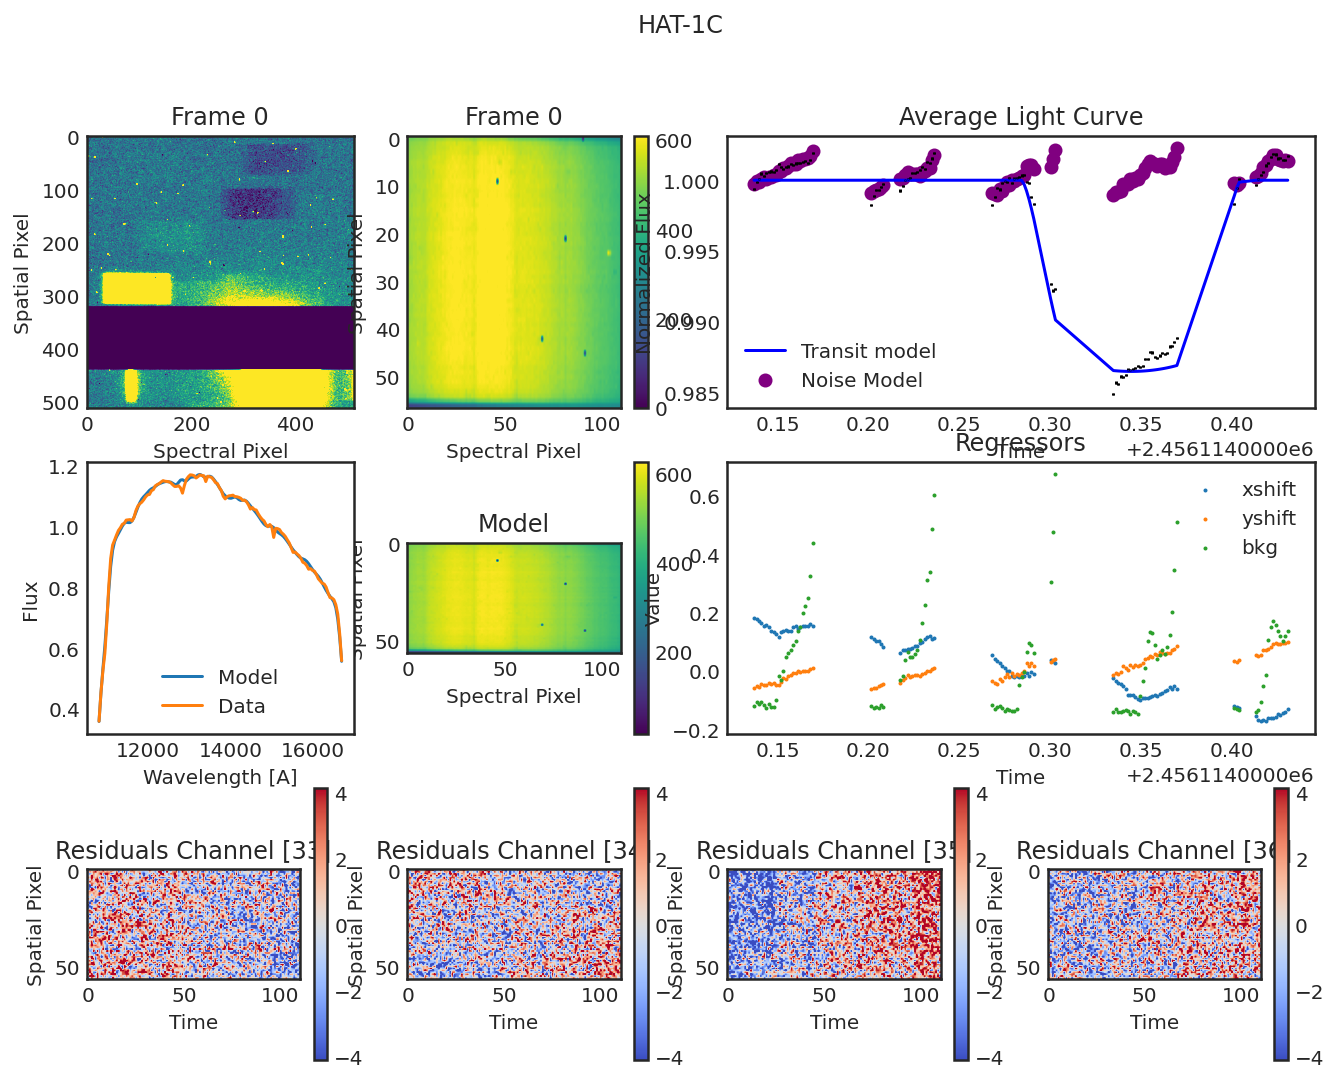

In [15]:
for visit in obs:
    visit.diagnose();
    plt.show();

## Companion

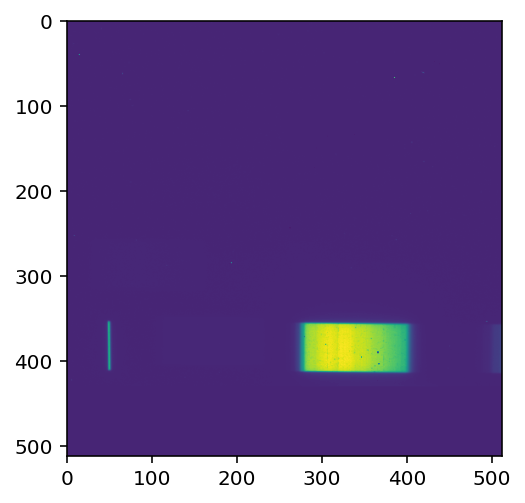

In [16]:
pixel_mask = np.ones((512, 512))
pixel_mask[430:] = 0
plt.imshow(fits.open(fnames[100])[1].data * pixel_mask)

In [17]:
obs2 = om.Observation.from_files(fnames, pixel_mask=pixel_mask)

/Users/ch/HST/projects/ombre/src/ombre/visit.py:208: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10


In [18]:
obs2.copy_transit_fit(obs)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

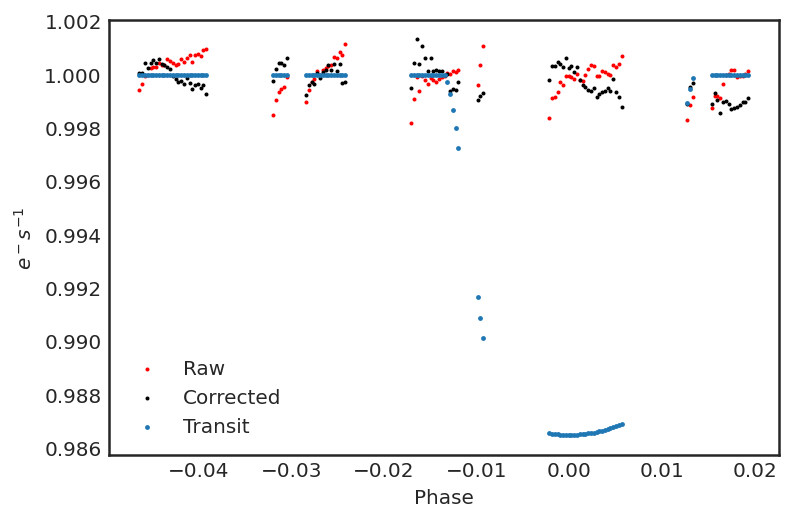

In [19]:
obs2.plot()

In [20]:
obs2.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model: 100%|██████████| 1/1 [00:16<00:00, 16.98s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 1/1 [00:16<00:00, 16.98s/it]

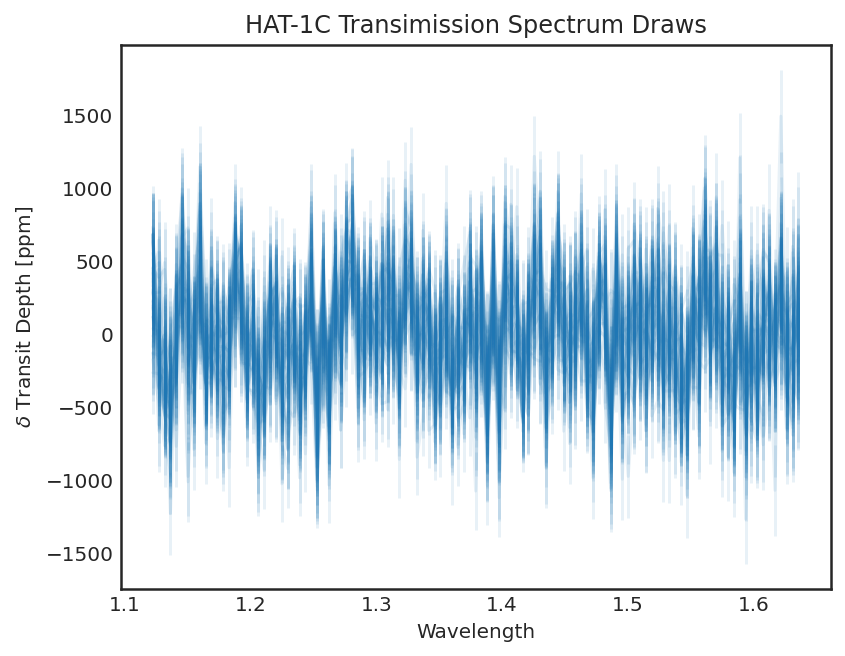

In [21]:
obs2.plot_spectra()

<AxesSubplot:title={'center':'HAT-1C Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

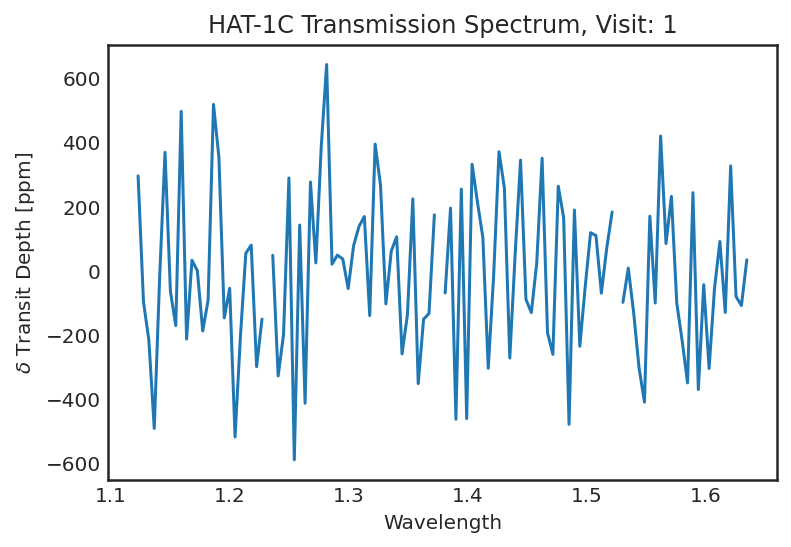

In [22]:
om.Spectra([visit.transmission_spectrum for visit in obs2]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

In [23]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/noplanets/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/noplanets/{name}_emission.fits', overwrite=True)
except:
    pass

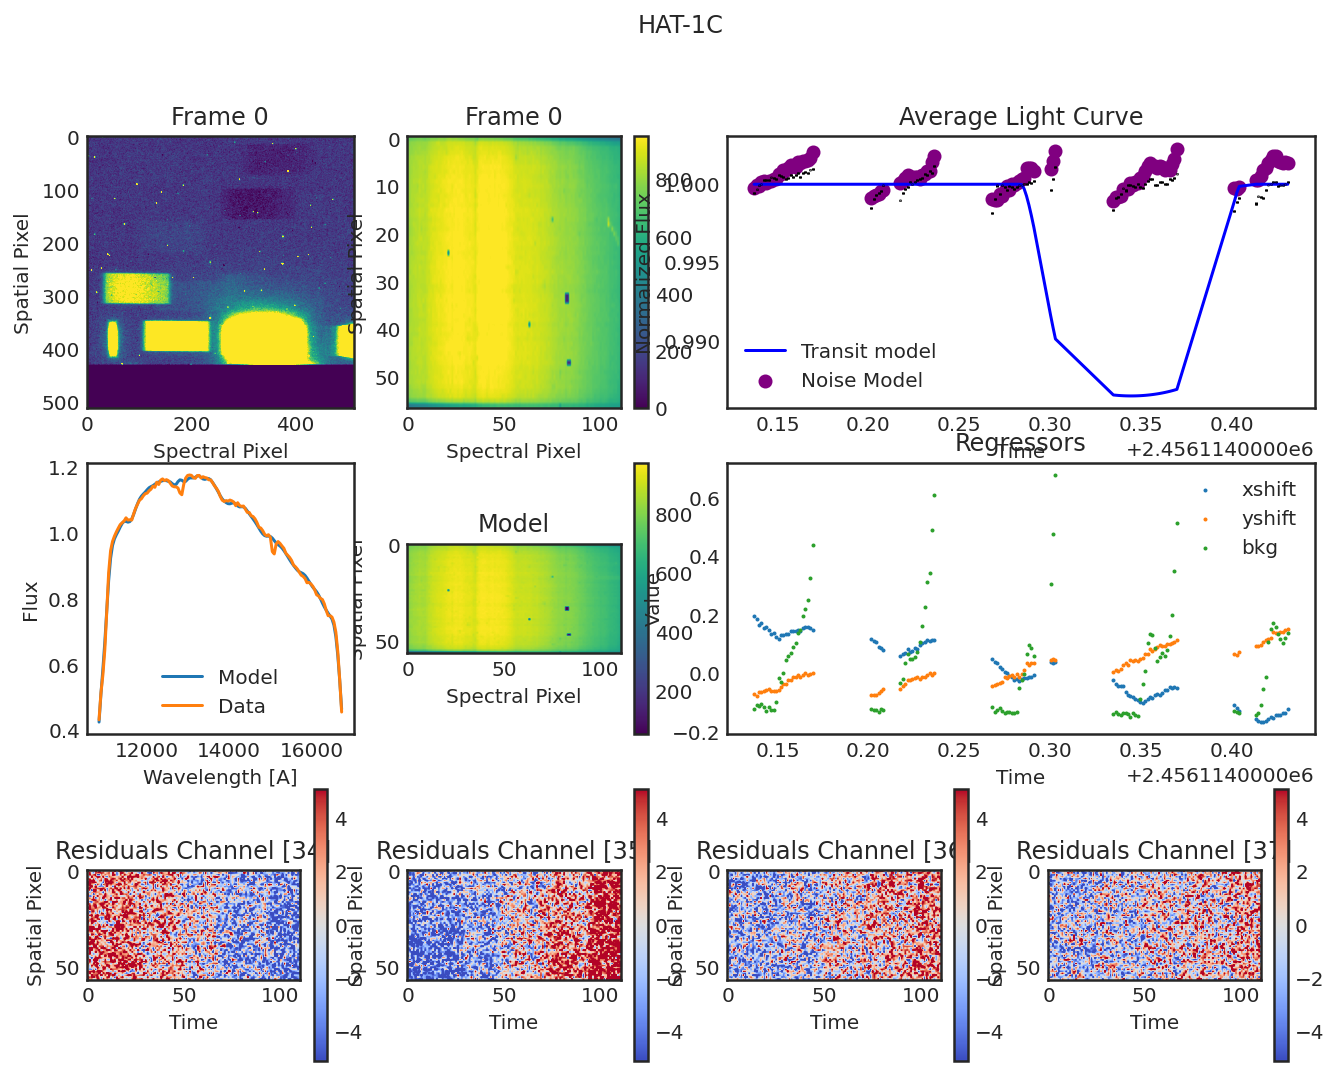

In [24]:
for visit in obs2:
    visit.diagnose();
    plt.show();